# [How to Record Fiber Response](https://portwooddigital.com/2021/07/25/how-to-record-fiber-response/) ([Prof.  Michael H. Scott](https://portwooddigital.com/author/staticsprof/))

In this jupyter notebook we take a look to the mentioned review and implement it by some small changes.

By: [Bijan Sayyafzadeh](linkedin.com/in/bijan-sayyafzadeh-6027aa7a) [Email](B.sayyaf@yahoo.com) [Github](https://github.com/BijanSeif)

The main pupose of the review is how to deal with fibers data and get results from them. The below model has been generated for this purpose:

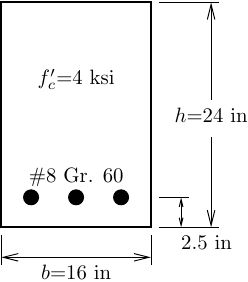

Description of the model by Prof. Scott:

*Using a zeroLengthSection element with displacement control on the nodal rotation, we know the curvature is the nodal rotation and the moment is the load factor. The model uses basic material models–Concrete01 with standard inputs for compressive and spalling strains, and EPP Steel01–for the fibers.*

In [ ]:
def Curvature():
    # This function returns section strain slope along height(y) or same Curvature 
    # This is handy calculation and also It  ops.eleResponse(ele,'section','deformation')
    data=ops.eleResponse(1,'section','fiberData')
    Ndata = len(data)
    y=data[0:Ndata:5] # Get Fibers y local location
    eps=data[4:Ndata:5] # Get fibers strain
    
    ymax=max(y)
    ymin=min(y)
    
    epsmax=eps[y.index(ymax)]
    epsmin=eps[y.index(ymin)]
    
    m=(epsmax-epsmin)/(ymax-ymin)
    
    
    # in concrete sections by cracking tensile fibers the natural axis location changes in each step and here it can be seen
    # ybar=ymax-epsmax/m #Location of natural axis or height that strain is zero
    
    
    
    return m
    

In [ ]:
import openseespy.opensees as ops

kip = 1.0
inch = 1.0

ft = 12*inch
ksi = kip/inch**2

fc = 4*ksi
fy = 60*ksi
E = 29000*ksi

Abar = 0.79*inch**2

h = 24*inch
b = 16*inch

ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

ops.node(1,0,0); ops.fix(1,1,1,1)
ops.node(2,0,0); ops.fix(2,0,1,0)

ops.uniaxialMaterial('Concrete01',1,fc,0.002,0,0.006)
ops.uniaxialMaterial('Steel01',2,fy,E,0)


ops.section('Fiber',1)
ops.patch('rect',1,20,1,-h/2,-b/2,h/2,b/2)
ops.layer('straight',2,3,Abar,-h/2+2.5*inch,b/2-2.5*inch,-h/2+2.5*inch,-b/2+2.5*inch)

ops.element('zeroLengthSection',1,1,2,1)

ops.timeSeries('Linear',1)
ops.pattern('Plain',1,1)
ops.load(2,0,0,1)

Ky = 0.003/(h/2) # ballpark estimate of yield curvature

# create the analysis
tol=0.0001
iter=1000
ops.constraints('Plain')               # how it handles boundary conditions
ops.numberer('Plain')                  # renumber dof's to minimize band-width (optimization), if you want to
ops.system('BandGen')              # how to store and solve the system of equations in the analysis
ops.algorithm('Linear')                # use Linear algorithm for linear analysis
ops.integrator('DisplacementControl',2,3,Ky/100)
ops.analysis("Static")                 # create analysis object


epsc = 0
AllData=[]
rslt=0
ele=1
K=[]

while epsc > -0.003 and rslt==0:
    rslt=ops.analyze(1)
    epsc = ops.nodeDisp(2,1) - h/2*ops.nodeDisp(2,3)
    

    #Get All Fiber Data From OpenSees:
    data=ops.eleResponse(1,'section','fiberData') #(Pr. M.Scott: Element 1, all sections) means that to get data for all sections do not mention hte section number after 'section'
    AllData.append(data)
    
    K.append(Curvature())
    # or:
    # K.append(ops.eleResponse(ele,'section','deformation')[1])
    
    
#     print(Curvature()) # Handy Curvature
#     print(f'ele{ele}:',ops.eleResponse(ele,'section','deformation')[1])  # OpenSees Curvature
    
#     print(f'ele{ele}:',ops.eleResponse(ele,'section','deformation')[0]) # ???
#     print(ops.nodeDisp(2)[0],'\n') # ???


In [ ]:
#Commands to get element sections tag and oweight and locations that because it is here is zero length we have no results but for the thers it will gives us the results
eletag=1
print('element end nodes tags=',ops.eleNodes(eletag))
[p1,p2]=ops.eleNodes(eletag)
p1=ops.nodeCoord(p1)
p2=ops.nodeCoord(p2)
print('element total length=',((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5)
print('element section locations=',ops.sectionLocation(eletag))
print('element section weight=',ops.sectionWeight(eletag))
print('element section tags=',ops.sectionTag(eletag))

In [ ]:
data=ops.eleResponse(1,'section','fiberData2') #New Feature that let to Get Materials Tag
data[3:len(data):6] #Get Materials Tag of each fiber

## Now Different results can be calclulated:
* Moment step
* Moment curvature
* Moment - Fibers Strain
* Moment - Concrete Fibers Stress
* Moment - Rebars Fibers Stress

***Also Remember that by decreasing the number of concrete fibers you will encounter with convergence problems!.***

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import math
import scipy as sc

#     data=ops.eleResponse(1,'section','fiberData') #(Pr. M.Scott: Element 1, all sections) means that to get data for all sections do not mention hte section number after 'section'

#Store Different data in lists
step=[]
y=[]
z=[]
A=[]
sig=[]
consig=[]
coneps=[]
stlsig=[]
stleps=[]
eps=[]
M=[]


for st,data in enumerate(AllData):
    step.append(st)
    Ndata = len(data)
    Nfibers = int(Ndata/5)
    #print(Ndata)    
    #print('Nfibers=',Nfibers, '\n')


    y=data[0:Ndata:5] # Get Fibers y local location
    z=data[1:Ndata:5] # For 2D models z is always equal to zero
    A=data[2:Ndata:5] # If you want each fiber areas

    # print('\ny=',(y[-1]),'\nz=',z[-1])
    # print('A=',A[-1],'\n')


    sig.append(data[3:Ndata:5]) # Get fibers stress
    eps.append(data[4:Ndata:5]) # Get fibers strain 
    
    # print('sig=',sig[-1])
    # print('eps=',(eps[-1]))  

    
    consig.append(sig[-1][0:-3]) # concrete fibers stress
    coneps.append(eps[-1][0:-3]) # concrete fibers strain
    stlsig.append(sig[-1][-3:])  # steel fibers stress
    stleps.append(eps[-1][-3:])  # concrete fibers strain
    #print('#= [ y   , z  , A   , sig, eps                  ]')
    #for i in range(11):
    #    print(f'{i}=',data[i*5:(i+1)*5])


    M.append(sum([yi*ai*sigi for yi,ai,sigi in zip(y,A,sig[-1])]))
    #print('\nM=',M[-1])


fig=0
plt.figure(fig)
plt.plot(step,[abs(m) for m in M])
plt.xlabel('Step')
plt.ylabel('M');
plt.title('Moment-Step')
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot([abs(k) for k in K],[abs(m) for m in M])
plt.xlabel('Kappa')
plt.ylabel('M');
plt.title('Moment-curvature')
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot([abs(m) for m in M],eps)
plt.xlabel('Moment')
plt.ylabel('fibers strain');
plt.title('Moment - Fibers Strain')
# plt.legend([f'y={yi}' for yi in y])
plt.grid()

fig=fig+1
plt.figure(fig)
sig=consig
plt.plot([abs(m) for m in M],sig)
plt.xlabel('Moment')
plt.ylabel('concrete fibers stress');
plt.title('Moment - Concrete Fibers Stress')
# plt.legend([f'y={yi}' for yi in y[0:-3]])
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot([abs(m) for m in M],stlsig)
plt.xlabel('Moment')
plt.ylabel('steel fibers stress');
plt.title('Moment - Rebars Fibers Stress')
plt.legend([f'y={yi}' for yi in y[-3:]])
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot(stleps,stlsig)
plt.xlabel('Steel Fibers Strain')
plt.ylabel('steel fibers stress');
plt.title('Rebars Fibers Strain - Stress')
plt.legend([f'y={yi}' for yi in y[-3:]])
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot(coneps,consig)
plt.xlabel('Concrete Fibers Strain')
plt.ylabel('concrete fibers stress');
plt.title('Concrete Fibers Strain - Stress')
# plt.legend([f'y={yi}' for yi in y[0:-3]])
plt.grid()

## Improve Above code using fiberData2

In [ ]:
import openseespy.opensees as ops

kip = 1.0
inch = 1.0

ft = 12*inch
ksi = kip/inch**2

fc = 4*ksi
fy = 60*ksi
E = 29000*ksi

Abar = 0.79*inch**2

h = 24*inch
b = 16*inch

ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

ops.node(1,0,0); ops.fix(1,1,1,1)
ops.node(2,0,0); ops.fix(2,0,1,0)

ops.uniaxialMaterial('Concrete01',1,fc,0.002,0,0.006)
ops.uniaxialMaterial('Steel01',2,fy,E,0)


ops.section('Fiber',1)
ops.patch('rect',1,20,1,-h/2,-b/2,h/2,b/2)
ops.layer('straight',2,3,Abar,-h/2+2.5*inch,b/2-2.5*inch,-h/2+2.5*inch,-b/2+2.5*inch)

ops.element('zeroLengthSection',1,1,2,1)

ops.timeSeries('Linear',1)
ops.pattern('Plain',1,1)
ops.load(2,0,0,1)

Ky = 0.003/(h/2) # ballpark estimate of yield curvature

# create the analysis
tol=0.0001
iter=1000
ops.constraints('Plain')               # how it handles boundary conditions
ops.numberer('Plain')                  # renumber dof's to minimize band-width (optimization), if you want to
ops.system('BandGen')              # how to store and solve the system of equations in the analysis
ops.algorithm('Linear')                # use Linear algorithm for linear analysis
ops.integrator('DisplacementControl',2,3,Ky/100)
ops.analysis("Static")                 # create analysis object


epsc = 0
AllData=[]
rslt=0
ele=1
K=[]

while epsc > -0.003 and rslt==0:
    rslt=ops.analyze(1)
    epsc = ops.nodeDisp(2,1) - h/2*ops.nodeDisp(2,3)
    

    #Get All Fiber Data From OpenSees:
    data=ops.eleResponse(1,'section','fiberData2') #(Pr. M.Scott: Element 1, all sections) means that to get data for all sections do not mention hte section number after 'section'
    AllData.append(data)
    
    K.append(Curvature())
    # or:
    # K.append(ops.eleResponse(ele,'section','deformation')[1])
    
    
#     print(Curvature()) # Handy Curvature
#     print(f'ele{ele}:',ops.eleResponse(ele,'section','deformation')[1])  # OpenSees Curvature
    
#     print(f'ele{ele}:',ops.eleResponse(ele,'section','deformation')[0]) # ???
#     print(ops.nodeDisp(2)[0],'\n') # ???


In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import math
import scipy as sc

#     data=ops.eleResponse(1,'section','fiberData') #(Pr. M.Scott: Element 1, all sections) means that to get data for all sections do not mention hte section number after 'section'

#Store Different data in lists
step=[]
y=[]
z=[]
A=[]
FiberMatTag=[]
sig=[]
consig=[]
coneps=[]
stlsig=[]
stleps=[]
eps=[]
M=[]


for st,data in enumerate(AllData):
    step.append(st)
    Ndata = len(data)
    Nfibers = int(Ndata/6)
    #print(Ndata)    
    #print('Nfibers=',Nfibers, '\n')


    y=data[0:Ndata:6] # Get Fibers y local location
    z=data[1:Ndata:6] # For 2D models z is always equal to zero
    A=data[2:Ndata:6] # If you want each fiber areas
    FiberMatTag=data[3:Ndata:6] # If you want each fiber material tag

    # print('\ny=',(y[-1]),'\nz=',z[-1])
    # print('A=',A[-1],'\n')


    sig.append(data[4:Ndata:6]) # Get fibers stress
    eps.append(data[5:Ndata:6]) # Get fibers strain 
    
    # print('sig=',sig[-1])
    # print('eps=',(eps[-1]))  

    
    consig.append(sig[-1][0:-3]) # concrete fibers stress
    coneps.append(eps[-1][0:-3]) # concrete fibers strain
    stlsig.append(sig[-1][-3:])  # steel fibers stress
    stleps.append(eps[-1][-3:])  # concrete fibers strain
    #print('#= [ y   , z  , A   , sig, eps                  ]')
    #for i in range(11):
    #    print(f'{i}=',data[i*5:(i+1)*5])


    M.append(sum([yi*ai*sigi for yi,ai,sigi in zip(y,A,sig[-1])]))
    #print('\nM=',M[-1])


fig=0
plt.figure(fig)
plt.plot(step,[abs(m) for m in M])
plt.xlabel('Step')
plt.ylabel('M');
plt.title('Moment-Step')
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot([abs(k) for k in K],[abs(m) for m in M])
plt.xlabel('Kappa')
plt.ylabel('M');
plt.title('Moment-curvature')
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot([abs(m) for m in M],eps)
plt.xlabel('Moment')
plt.ylabel('fibers strain');
plt.title('Moment - Fibers Strain')
# plt.legend([f'y={yi}' for yi in y])
plt.grid()

fig=fig+1
plt.figure(fig)
sig=consig
plt.plot([abs(m) for m in M],sig)
plt.xlabel('Moment')
plt.ylabel('concrete fibers stress');
plt.title('Moment - Concrete Fibers Stress')
# plt.legend([f'y={yi}' for yi in y[0:-3]])
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot([abs(m) for m in M],stlsig)
plt.xlabel('Moment')
plt.ylabel('steel fibers stress');
plt.title('Moment - Rebars Fibers Stress')
plt.legend([f'y={yi}' for yi in y[-3:]])
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot(stleps,stlsig)
plt.xlabel('Steel Fibers Strain')
plt.ylabel('steel fibers stress');
plt.title('Rebars Fibers Strain - Stress')
plt.legend([f'y={yi}' for yi in y[-3:]])
plt.grid()

fig=fig+1
plt.figure(fig)
plt.plot(coneps,consig)
plt.xlabel('Concrete Fibers Strain')
plt.ylabel('concrete fibers stress');
plt.title('Concrete Fibers Strain - Stress')
# plt.legend([f'y={yi}' for yi in y[0:-3]])
plt.grid()